# PySensors Overview
This notebook is meant to give an overview of the basic functionality of `PySensors`. See our other notebooks for more detailed information about different methods and tasks.

Given measurement data `PySensors` helps one choose a sparse set of sensor locations for either *reconstruction* (interpolation) or *classification*. `PySensors` was written to be fully compatible with `Scikit-learn`. As such, most of its objects are `Scikit-learn` estimators, expecting training data to be `numpy` arrays with rows corresponding to examples and columns to features. Throughout `PySensors` it is typically assumed that different features (columns of measurement data) correspond to different sensors or sensor locations.

For examples showing how to perform cross-validation with `Scikit-learn` and `PySensors` objects, see [this notebook](https://github.com/dynamicslab/pysensors/blob/master/examples/cross_validation.ipynb).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split

import pysensors as ps

In [2]:
# Seed for reproducibility
random_state = 99

## Reconstruction
For our reconstruction examples we will consider the Olivetti faces dataset from AT&T, consisting of 10 64-by-64 pictures of 40 different people. Each pixel will be treated as a sensor. An additional example performing sensor selection with `PySensors` to approximate global sea surface temperatures is given [here](https://github.com/dynamicslab/pysensors/blob/master/examples/sea_surface_temperature.ipynb)

For reconstruction `PySensors` provides the `SSPOR` class (Sparse Sensor Placement Optimization for Reconstruction), which is largely based on the following paper ([link](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8361090)):

    Manohar, Krithika, et al. "Data-driven sparse sensor placement for reconstruction: Demonstrating the benefits of exploiting known patterns." IEEE Control Systems Magazine 38.3 (2018): 63-86.
    
`SSPOR` objects can be imported directly from `pysensors` or from `pysensors.reconstruction`.

### Setup

In [3]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=random_state)
X = faces.data

n_samples, n_features = X.shape
print('Number of samples:', n_samples)
print('Number of features (sensors):', n_features)

# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

X_train, X_test = X[:300], X[300:]

Number of samples: 400
Number of features (sensors): 4096


In [4]:
# From https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    '''Function for plotting faces'''
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

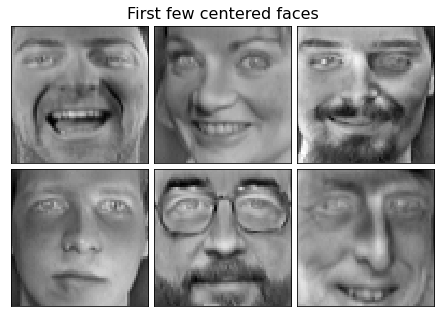

In [5]:
plot_gallery("First few centered faces", X[:n_components])

### Simplest case
A `SSPOR` object is instantiated and fit to the data to obtain a ranking of sensors (technically sensor indices) in descending order of importance. We print the top 10 here.

In [6]:
model = ps.SSPOR()
model.fit(X_train)

# Ranked list of sensors
ranked_sensors = model.get_selected_sensors()
print(ranked_sensors[:10])

[4032 4092  320 4039 2209  575  529 2331  878 2837]


Here we visualize the locations of the top 60 sensors.

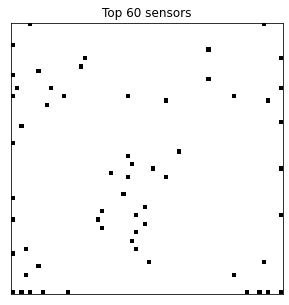

In [7]:
# Plot the top 60 sensors
n_sensors = 60
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

img = np.zeros(n_features)
img[ranked_sensors[:n_sensors]] = 16

ax.imshow(img.reshape(image_shape), cmap=plt.cm.binary)
ax.set(title=f'Top {n_sensors} sensors', xticks=[], yticks=[]);

### Changing the number of sensors
Since we didn't specify the number of sensors, `SSPOR.get_selected_sensors()` returned them all.
Instead we can pass in the desired number of sensors when instantiating a `SSPOR` object or after it has been fitted. Both options yield the same result.

In [8]:
# Set number of sensors after fitting
model.set_number_of_sensors(n_sensors)

# Set number of sensors before fitting
model_alt = ps.SSPOR(n_sensors=n_sensors)
model_alt.fit(X_train)

print('Number of sensors originally returned:', len(ranked_sensors))
print('Number of returned sensors after updating:', len(model.get_selected_sensors()))

assert all(model.get_selected_sensors() == model_alt.get_selected_sensors())

Number of sensors originally returned: 4096
Number of returned sensors after updating: 60


### Forming reconstructions
Once a `SSPOR` model has been fit to the data, it can be used to form reconstructions based on measurements from the selected sensor locations.

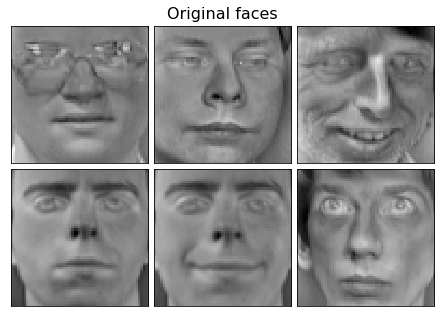

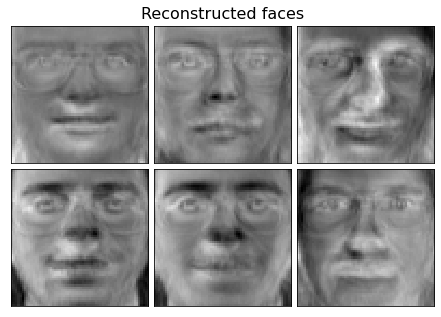

In [9]:
# Fit the model
n_sensors = 60
model = ps.SSPOR(n_sensors=n_sensors).fit(X_train)

# Get the chosen sensor locations
sensors = model.get_selected_sensors()

# Subsample data so we only have measurements at chosen sensor locations
X_test_subsampled = X_test[:, sensors]

# Form reconstructions
X_test_reconstructed = model.predict(X_test_subsampled)

plot_gallery("Original faces", X_test[:n_components])
plot_gallery("Reconstructed faces", X_test_reconstructed[:n_components])

### Sweeping over a range of sensor counts
It is often useful to measure the reconstruction error as a function of the number of sensors.

Note that the error tends to spike when the number of sensors is close to the total number of examples (or the number of basis modes); in this case 300.

Another example of this functionality is given [here](https://github.com/dynamicslab/pysensors/blob/master/examples/vandermonde.ipynb).

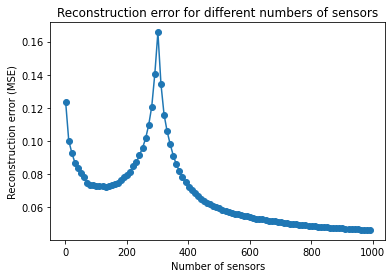

In [10]:
model = ps.SSPOR().fit(X_train)

sensor_range = np.arange(1, 1000, 10)
errors = model.reconstruction_error(X_test, sensor_range=sensor_range)

plt.plot(sensor_range, errors, '-o')
plt.xlabel('Number of sensors')
plt.ylabel('Reconstruction error (MSE)')
plt.title('Reconstruction error for different numbers of sensors');

### Changing the basis
`PySensors` currently provides three choices of basis in which to represent measurement data:

* `Identity`: uses the raw measurements (the default option)
* `SVD`: Singular Value Decomposition modes (equivalent to PCA modes if the data are centered)
* `RandomProjection`: Random Gaussian projections of the data

These classes are all contained in the `pysensors.basis` submodule. For a comparison of these options see [this notebook](https://github.com/dynamicslab/pysensors/blob/master/examples/basis_comparison.ipynb).

In [11]:
n_basis_modes = 20

#### SVD basis

In [12]:
basis = ps.basis.SVD(n_basis_modes=n_basis_modes)
model = ps.SSPOR(basis=basis)
model.fit(X_train)

# Ranked list of sensors
svd_ranked_sensors = model.get_selected_sensors()
print('Original ranked sensors:', ranked_sensors[:10])
print('SVD ranked sensors:', svd_ranked_sensors[:10])

Original ranked sensors: [4032 4092  320 4039 2209  575  529 2331  878 2837]
SVD ranked sensors: [2209  319 3970  384 3034 4092  594 2331 2813 2839]


#### Random projections

In [13]:
basis = ps.basis.RandomProjection(n_basis_modes=n_basis_modes)
model = ps.SSPOR(basis=basis)
model.fit(X_train)

# Ranked list of sensors
rp_ranked_sensors = model.get_selected_sensors()
print('Original ranked sensors:', ranked_sensors[:10])
print('Random projection ranked sensors:', rp_ranked_sensors[:10])

Original ranked sensors: [4032 4092  320 4039 2209  575  529 2331  878 2837]
Random projection ranked sensors: [4035  130 2967  590  383 1024 2783 2457 3912 3072]


#### Updating the number of basis modes
The number of basis modes can be updated after a `SSPOR` model has been fit via the `update_n_basis_modes` function.

Note that when using `update_n_basis_modes` to *increase* the number of basis modes from the number specified when the model was fit requires one to pass in the training data. The number of basis modes can be decreased without the need for the training data.

In [14]:
# Decreasing the number of basis modes
basis = ps.basis.SVD(n_basis_modes=20)
model = ps.SSPOR(basis=basis).fit(X_train)
model.update_n_basis_modes(10)

# Increasing the number of basis modes
basis = ps.basis.SVD(n_basis_modes=20)
model = ps.SSPOR(basis=basis).fit(X_train)
model.update_n_basis_modes(30, x=X_train)

### Cost-constraints
For many applications sensors impose non-uniform costs depending on their locations. For example, if we wanted to place sensors around the planet to estimate temperatures at every point on Earth, it would be more expensive (financially) to set up sensors in Antarctica than in Seattle. However, some sensor locations may provide enough information to outweigh this cost.

To handle cost-constrained sensor selection problems, `PySensors` provides the `CCQR` (cost-constrained QR) optimization method. One simply instantiates a `CCQR` object and passes it a vector of sensor costs. More examples are available in [this notebook](https://github.com/dynamicslab/pysensors/blob/master/examples/cost_constrained_qr.ipynb).

See the following reference for the mathematical details ([link](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8579238)):

    Clark, Emily, et al. "Greedy sensor placement with cost constraints." IEEE Sensors Journal 19.7 (2018): 2642-2656.

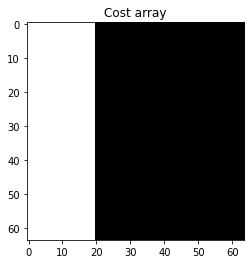

In [15]:
# Define cost array
costs = np.zeros(image_shape)
costs[:, :20] = 1

plt.imshow(costs, vmin=0, vmax=1, cmap=plt.cm.gray)
plt.title('Cost array');

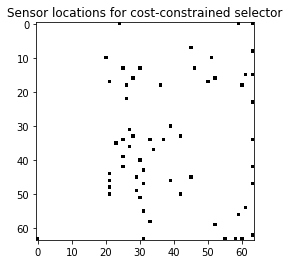

In [16]:
costs = costs.reshape(-1)

# Fit the cost-constrained model
optimizer = ps.optimizers.CCQR(sensor_costs=costs)
model = ps.SSPOR(optimizer=optimizer, n_sensors=n_sensors)
model.fit(X_train)

# Visualize the top sensors
top_sensors = model.get_selected_sensors()
img = np.zeros(n_features)
img[top_sensors] = 16
plt.imshow(img.reshape(image_shape), cmap=plt.cm.binary)
plt.title('Sensor locations for cost-constrained selector');

## Classification
For the classification examples we will consider the digits dataset. Each example consists of an 8-by-8 image of a handwritten digit. The goal is to train a model to identify which digit is written in a given image. In-depth examples are given in the [classification notebook](http://localhost:8888/notebooks/examples/classification.ipynb).

`PySensors` implements the Sparse Sensor Placement Optimization for Classification (SSPOC) algorithm in the `SSPOC` class. See the original SSPOC paper for more information ([link](https://epubs.siam.org/doi/pdf/10.1137/15M1036713)):

    Brunton, Bingni W., et al. "Sparse sensor placement optimization for classification." SIAM Journal on Applied Mathematics 76.5 (2016): 2099-2122.

`SSPOC` can be imported directly from `pysensors` or from `pysensors.classification`.

In [17]:
from pysensors import SSPOC

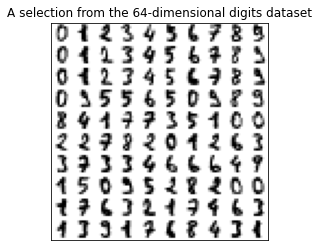

Number of samples: 1797


In [18]:
# Load data
digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state
)

# Plot some digits
n_img_per_row = 10
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

print('Number of samples:', n_samples)

### Simplest case

In [19]:
model = SSPOC()
model.fit(X_train, y_train)

print('Portion of sensors used:', len(model.selected_sensors) / n_features)
print('Selected sensors:', model.selected_sensors)

Portion of sensors used: 0.0625
Selected sensors: [16 24 31 48]


### Changing the number of sensors
There are a few methods of changing the number of sensors for `SSPOC` objects:

1. Specify `n_sensors` when instantiating the model.
2. Change the `l1_penalty` parameter. This affects the strength of the regularization applied when finding sensor locations. If `n_sensors` is not passed to the `SSPOC` constructor, then the value of `l1_penalty` can affect the number of sensors that are selected. You can also tune the `threshold` parameter to further affect the sensor count.
3. Update `n_sensors` after fitting. Use the `update_sensors` function to do so. It is recommended that you also pass in the training and test data so that the classifier can be refit using the new sensors.

See the [classification notebook](http://localhost:8888/notebooks/examples/classification.ipynb) for more information.

In [20]:
# Method 1
model = SSPOC(n_sensors=10).fit(X_train, y_train, quiet=True)
print('Portion of sensors used:', len(model.selected_sensors) / n_features)
print('Selected sensors:', model.selected_sensors)

Portion of sensors used: 0.15625
Selected sensors: [24 48 16 31 35 36 37 38 39 40]


In [21]:
# Method 2 - only works for multiclass classification problems
model = SSPOC(l1_penalty=0.01).fit(X_train, y_train)
print('Portion of sensors used (default threshold):', len(model.selected_sensors) / n_features)
print('Selected sensors:', model.selected_sensors)

# Tune threshold to affect number of sensors chosen
model = SSPOC(threshold=1, l1_penalty=0.01).fit(X_train, y_train)
print('\n')
print('Portion of sensors used (higher threshold):', len(model.selected_sensors) / n_features)
print('Selected sensors:', model.selected_sensors)

Portion of sensors used (default threshold): 0.59375
Selected sensors: [ 1  3  5  6  7  8 10 12 15 16 18 20 21 22 23 24 30 31 33 38 40 41 42 43
 44 45 46 47 48 49 52 53 55 57 60 61 62 63]


Portion of sensors used (higher threshold): 0.140625
Selected sensors: [ 8 15 16 23 24 31 40 47 48]


In [22]:
# Method 3 - update after fitting
model = SSPOC().fit(X_train, y_train)
model.update_sensors(n_sensors=10, xy=(X_train, y_train), quiet=True)
print('Portion of sensors used:', len(model.selected_sensors) / n_features)
print('Selected sensors:', model.selected_sensors)

Portion of sensors used: 0.15625
Selected sensors: [24 48 16 31 35 36 37 38 39 40]


### Changing the basis
Like the `SSPOR` object, `SSPOC` instances accept a `basis` argument.

In [23]:
basis = ps.basis.SVD(n_basis_modes=10)
model = SSPOC(basis=basis).fit(X_train, y_train)
print('Portion of sensors used:', len(model.selected_sensors) / n_features)
print('Selected sensors:', model.selected_sensors)

Portion of sensors used: 1.0
Selected sensors: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


### Changing the classifier
Additionally, one has the option to specify the classifier the `SSPOC` object uses. Any linear classifier with `fit` and `predict` methods and a `coef_` attribute are compatible.

In [24]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(max_iter=5000, loss='modified_huber', random_state=random_state)
model = SSPOC(classifier=classifier, n_sensors=10).fit(X_train, y_train, quiet=True)
print('Portion of sensors used:', len(model.selected_sensors) / n_features)
print('Selected sensors:', model.selected_sensors)

Portion of sensors used: 0.15625
Selected sensors: [43 53 12 28 61 27 26 30 52 42]


### Measuring accuracy
Once fit, `SSPOC` objects can also be used to make class predictions.

The `predict` method transforms the (subsampled) data to the appropriate basis, then applies the classifier to obtain predicted labels. These can then be used to check the accuracy of the model on the test set.

In [25]:
y_pred = model.predict(X_test[:, model.selected_sensors])
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.78
